In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
color1 = "ch:rot=-.25,hue=1,light=.75"
color2 = "colorblind"

In [2]:
weekly_df = pd.read_csv("data/infopld_clean.csv")
consumo   = pd.read_csv("data/consumo_clean.csv")

# **PLD vs TEMPO**

**Todo mês de abril a energia é mais barata?**

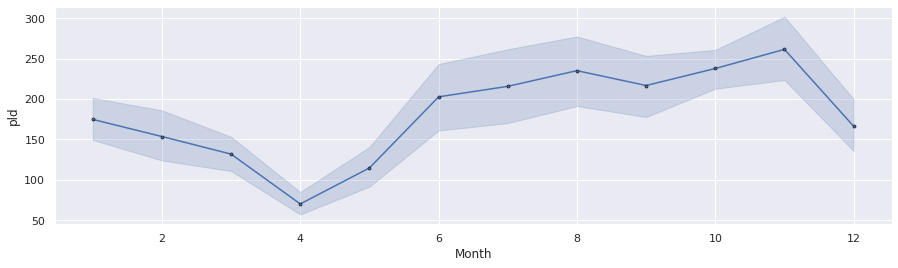

In [3]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(x="Month", y="pld", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.show()

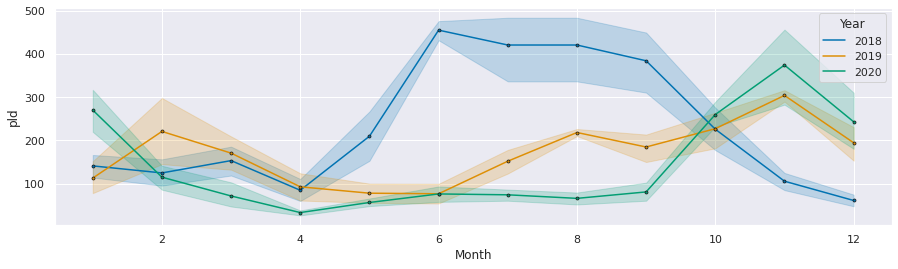

In [4]:
fig = plt.figure(figsize=(15,4))
sns.lineplot(x="Month", y="pld", hue="Year", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.axhline(y=100, lw=1.5, ls='--', c='red')
plt.show()

**Sera que o preço no norderse é mais cara que o preço na sul? Existe variação regional?**

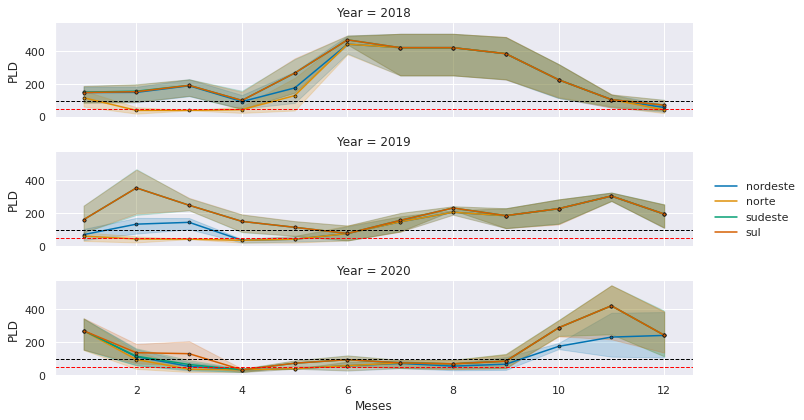

In [5]:
g = sns.FacetGrid(weekly_df, row="Year", height=2, aspect=5)
g.map_dataframe(sns.lineplot, x="Month", y="pld", hue='submercado', 
                palette=color2, marker='o', markersize=3, mec='k', lw=1.5)

g.map(plt.axhline, y=100, lw=1, ls='--', c='black')
g.map(plt.axhline, y=50,  lw=1, ls='--', c='red')

g.set_axis_labels("Meses", "PLD")
g.add_legend()
g.tight_layout()
plt.show()

**Existem diversas formas de visualizar os dados.**

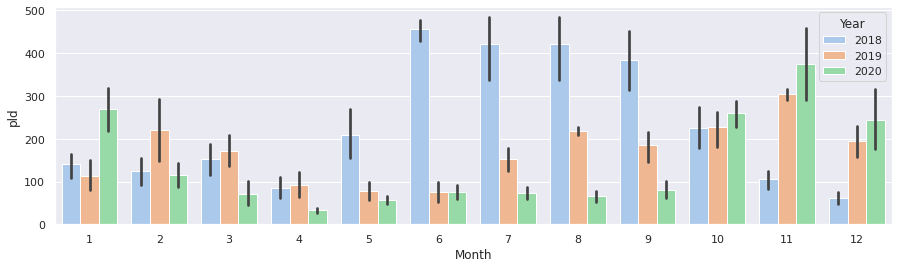

In [6]:
fig = plt.figure(figsize=(15,4))
sns.barplot(x="Month", y="pld", data=weekly_df,
            hue='Year',color="b", palette='pastel')
plt.show()

**Vamos ver a série histórica do preço da energia:**

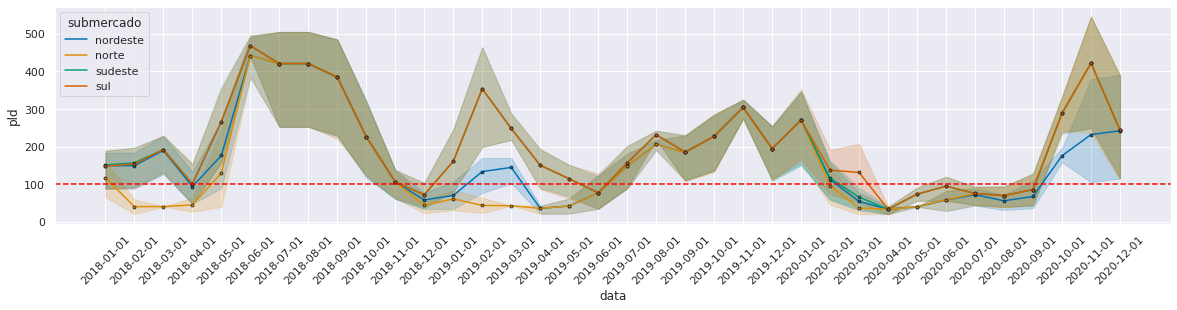

In [14]:
fig = plt.figure(figsize=(20,4))
sns.lineplot(x="data", y="pld", hue ="submercado", data=weekly_df, palette=color2, marker='o', markersize=3, mec='k', lw=1.5)
plt.axhline(y=100, lw=1.5, ls='--', c='red')
plt.xticks(rotation=45)
plt.show()

---

Vamos olhar para alguma variável que pode explicar esses gráficos?

In [16]:
from functions import infopld_normalize, word_normalize

In [22]:
def infopld_normalize(df):

    submercado = df['Submercado'].apply(word_normalize)
    semana = df["Nº Semana"].astype("category").cat.codes + 1
    
    df= df.rename(columns={"Nº Semana":"semana", "Submercado":'submercado'})\
          .assign(semana=semana)\
          .assign(submercado=submercado)\
          .groupby(["submercado", "semana"],as_index=False)\
          .agg(np.mean)\
          .fillna(0)
    
    return df

In [32]:
consumo_df = pd.read_csv("data/consumo_clean.csv")

infopld = pd.ExcelFile("data/infopld.xlsx")
infopld_2018_df = infopld.parse("PLD2018",encoding='ISO-8859-1') 
infopld_2019_df = infopld.parse("PLD2019") 
infopld_2020_df = infopld.parse("PLD2020") 

#pld cleaning
infopld18_clean = infopld_normalize(infopld_2018_df)
infopld19_clean = infopld_normalize(infopld_2019_df)
infopld20_clean = infopld_normalize(infopld_2020_df)

columns18_agg = infopld18_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
columns19_agg = infopld19_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
columns20_agg = infopld20_clean.filter(regex=r"\d{4}-\d{2}-\d{2}").columns
aux1=pd.pivot_table(infopld18_clean, values = columns18_agg, index='submercado', aggfunc=np.mean, fill_value=0).T
aux2=pd.pivot_table(infopld19_clean, values = columns19_agg, index='submercado', aggfunc=np.mean, fill_value=0).T
aux3=pd.pivot_table(infopld20_clean, values = columns20_agg, index='submercado', aggfunc=np.mean, fill_value=0).T

analysis_df = pd.concat([aux1, aux2, aux3])
analysis_df = analysis_df.reset_index()\
                         .rename(columns={"index":"Data"})

consumo_df["Data"] = pd.to_datetime(consumo_df["Data"])
analysis_df = pd.merge(analysis_df.melt(id_vars="Data",value_name="pld"), consumo_df, on=["Data","submercado"])
analysis_df[["Year", "Month"]] = analysis_df.apply(lambda x: (x['Data'].year, x['Data'].month), axis = 1, result_type='expand')
analysis_df["Month"] = analysis_df["Month"].astype(str)
analysis_df["Year"] = analysis_df["Year"].astype(str)

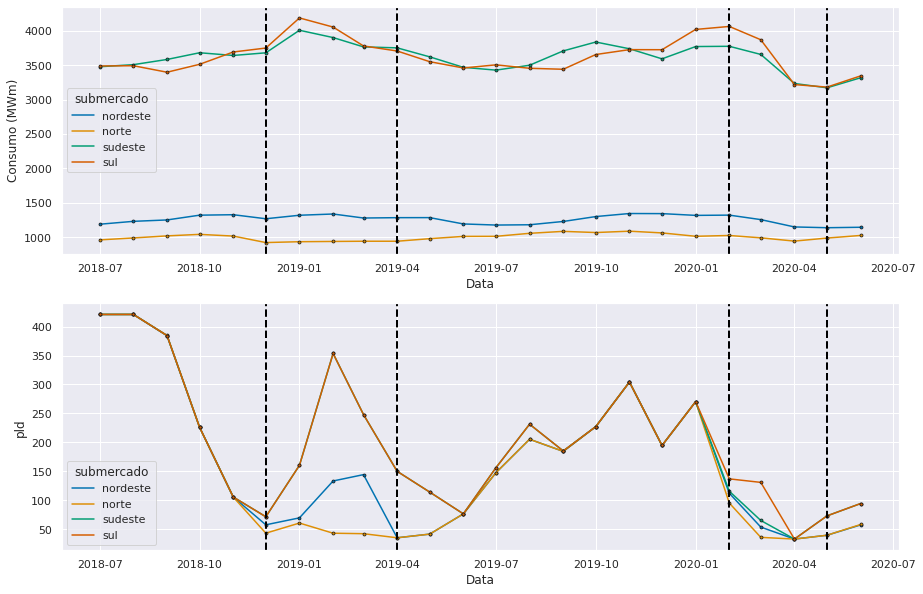

In [33]:
fig, axs = plt.subplots(2,1,figsize=(15,10))

sns.lineplot(
    x="Data", y="Consumo (MWm)",hue="submercado",
    data=analysis_df, ax = axs[0],
    palette=color2, marker='o', markersize=3, mec='k', lw=1.5)

axs[0].axvline(x=pd.to_datetime("2018-12-1"), lw=2, ls='--', c='black')
axs[0].axvline(x=pd.to_datetime("2019-04-1"), lw=2, ls='--', c='black')

axs[0].axvline(x=pd.to_datetime("2020-02-1"), lw=2, ls='--', c='black')
axs[0].axvline(x=pd.to_datetime("2020-05-1"), lw=2, ls='--', c='black')


sns.lineplot(
    x="Data", y="pld", hue ="submercado", 
    data=analysis_df, ax = axs[1],
    palette=color2, marker='o', markersize=3, mec='k', lw=1.5)

axs[1].axvline(x=pd.to_datetime("2018-12-1"), lw=2, ls='--', c='black')
axs[1].axvline(x=pd.to_datetime("2019-04-1"), lw=2, ls='--', c='black')

axs[1].axvline(x=pd.to_datetime("2020-02-1"), lw=2, ls='--', c='black')
axs[1].axvline(x=pd.to_datetime("2020-05-1"), lw=2, ls='--', c='black')

plt.show()